In [1]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import umap as umap

import scanpy as sc
import anndata

## scATAC-Seq
Using **ChromVAR** to calculate the k-mer z-score matrix from **scATAC-Seq** data. Use the feature matrix of z-score for trajectory inference.

In [2]:
scATAC_tfscore = pd.read_csv("./raw/scATAC_tfscore.csv", sep = ",", index_col = 0)
scATAC_tfscore.head()

,ENSG00000008196_LINE2_TFAP2B_D_N1,ENSG00000008196_LINE3_TFAP2B_D_N1,ENSG00000008196_LINE4_TFAP2B_D_N1,ENSG00000008196_LINE5_TFAP2B_D_N1,ENSG00000008197_LINE6_TFAP2D_D,ENSG00000087510_LINE7_TFAP2C_D_N3,ENSG00000087510_LINE12_TFAP2C_D_N2,ENSG00000087510_LINE13_TFAP2C_D_N2,ENSG00000087510_LINE14_TFAP2C_D_N2,ENSG00000087510_LINE8_TFAP2C_D_N1,...,ENSG00000120693_LINE19389_SMAD9_I_N1,ENSG00000120693_LINE19390_SMAD9_I_N1,ENSG00000120693_LINE19391_SMAD9_I_N1,ENSG00000120693_LINE19392_SMAD9_I_N1,ENSG00000110693_LINE19574_SOX6_I_N7,ENSG00000110693_LINE19569_SOX6_I_N1,ENSG00000112837_LINE19949_TBX18_I_N1,ENSG00000112837_LINE19950_TBX18_I_N1,ENSG00000122145_LINE20002_TBX22_I_N1,ENSG00000122145_LINE20003_TBX22_I_N1
cellname,,,,,,,,,,,,,,,,,,,,,
singles-BM0828-HSC-fresh-151027-1,-0.84034,0.40744,-1.20670,0.489410,-0.87663,-0.47600,-0.751300,0.22765,-1.50740,0.698450,...,0.020046,-0.63593,-1.31980,-0.16264,-1.71410,0.470720,0.74096,-0.035966,0.74096,-0.035966
singles-BM0828-HSC-fresh-151027-2,-0.29338,-0.60210,0.47999,0.736140,0.46593,0.53029,-0.131590,-1.89470,0.69155,-0.239230,...,0.285160,-1.49380,-1.30080,-2.45210,-1.38670,0.043402,-1.00480,2.089800,-1.00480,2.089800
singles-BM0828-HSC-fresh-151027-3,-2.26680,0.29362,-1.45240,-0.079287,0.53485,-1.50400,-2.048600,-0.21798,-1.51760,-1.397400,...,-0.429310,0.11038,-0.61102,-0.85499,0.16768,-0.543430,-0.29345,0.072564,-0.29345,0.072564
singles-BM0828-HSC-fresh-151027-4,-0.85146,-1.51830,-2.08720,-0.395140,-1.00440,-1.42200,-0.708890,-1.93880,-1.84100,-0.428110,...,-0.511970,-2.08480,-1.61230,-0.61207,1.28240,0.765460,-0.63118,-0.643090,-0.63118,-0.643090
singles-BM0828-HSC-fresh-151027-5,0.69698,0.73263,0.48880,0.250660,0.29524,-0.85568,0.002218,0.65011,0.78933,0.032639,...,1.216000,-0.50780,-0.56950,-2.10040,-0.17399,-0.244760,-1.91350,-1.048500,-1.91350,-1.048500


In [3]:
celltypes_atac = []
with open("./raw/scATAC_celltype.txt", "r") as fp:
    for line in fp:
        celltypes_atac.append(line.strip("\n"))

celltypes_atac = np.array(celltypes_atac)

## Remove non-overlapping clusters

In [4]:
neg_index = np.concatenate((np.where(celltypes_atac == "pDC")[0], np.where(celltypes_atac == "Mono")[0], np.where(celltypes_atac == "UNK")[0]))
indices = np.ones((2034,))
indices[neg_index] = 0
indices = (indices == 1)
scATAC = scATAC_tfscore.iloc[indices,:]
celltypes_atac = celltypes_atac[indices]
celltypes_atac[np.concatenate((np.where(celltypes_atac == "GMP1low")[0], np.where(celltypes_atac == "GMP2mid")[0], np.where(celltypes_atac == "GMP3high")[0]))] = "GMP"

In [5]:
umap_op = umap.UMAP(n_components=2, n_neighbors = 5)
x_umap = umap_op.fit_transform(scATAC.values)
pca_op = PCA(n_components = 2)
x_pca = pca_op.fit_transform(scATAC.values)

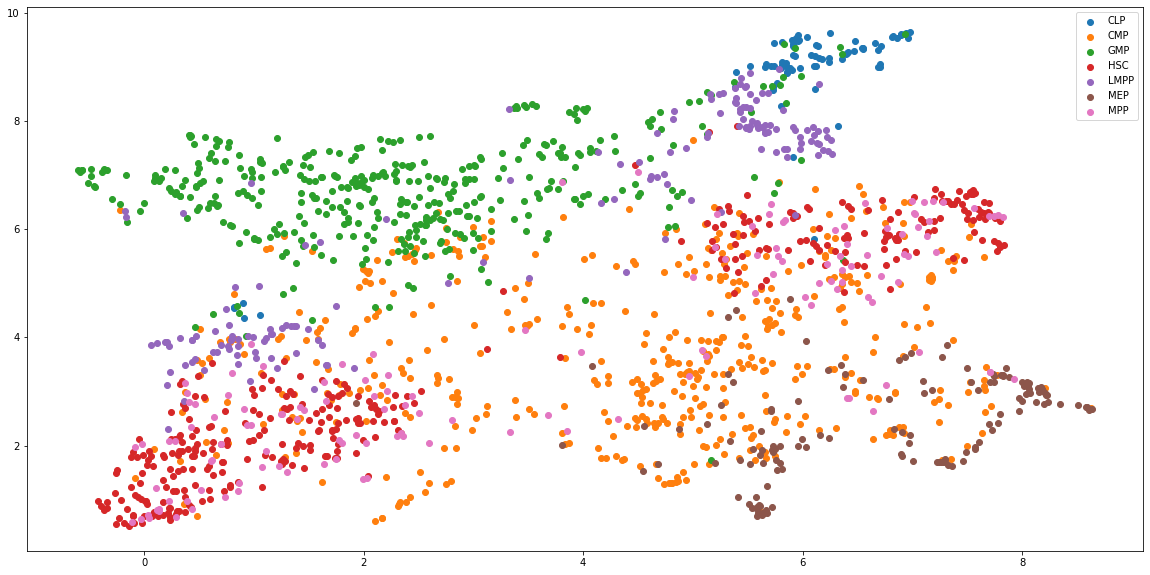

In [6]:
fig = plt.figure(figsize = (20,10))
ax = fig.subplots(1)
for cluster in np.unique(celltypes_atac):
    ax.scatter(x_umap[np.where(celltypes_atac == cluster)[0],0], x_umap[np.where(celltypes_atac == cluster)[0],1], label = cluster)

ax.legend()

## Remove double-clusters for HSC, MPP and LMPP

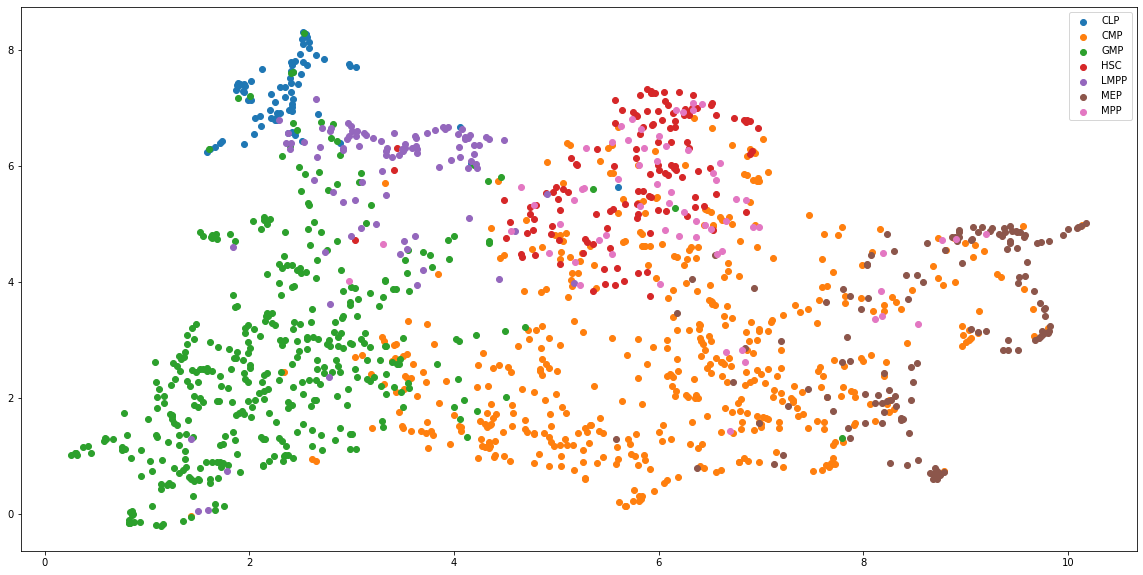

In [11]:
index = (x_umap[:,0]<4) & (x_umap[:,1]<6) & ((celltypes_atac == "HSC")|(celltypes_atac == "MPP")|(celltypes_atac == "LMPP"))
indices = np.ones((celltypes_atac.shape[0],))
indices[index] = 0
indices = (indices == 1)
scATAC_1head = scATAC.iloc[indices,:]
celltypes_atac_1head = celltypes_atac[indices]
umap_op = umap.UMAP(n_components=2, n_neighbors = 5)
x_umap = umap_op.fit_transform(scATAC_1head.values)
pca_op = PCA(n_components = 2)
x_pca = pca_op.fit_transform(scATAC_1head.values)
fig = plt.figure(figsize = (20,10))
ax = fig.subplots(1)
for cluster in np.unique(celltypes_atac_1head):
    ax.scatter(x_umap[np.where(celltypes_atac_1head == cluster)[0],0], x_umap[np.where(celltypes_atac_1head == cluster)[0],1], label = cluster)

ax.legend()

## Remove GMP

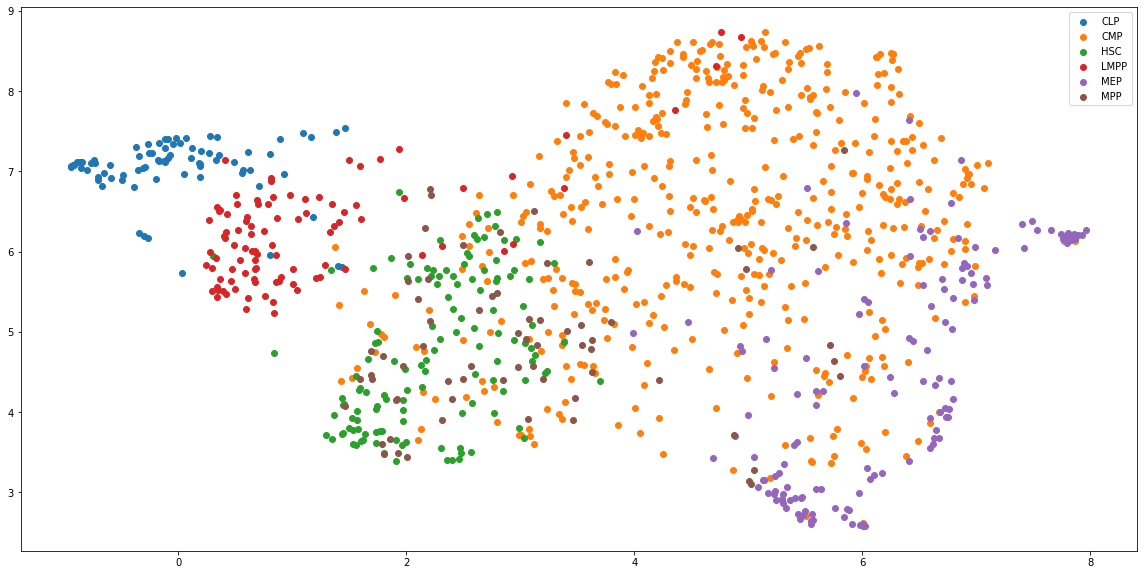

In [14]:
GMP_idx = np.where(celltypes_atac_1head == "GMP")[0]
indices = np.ones((celltypes_atac_1head.shape[0],))
indices[GMP_idx] = 0
indices = (indices == 1)
scATAC_1head2 = scATAC_1head.iloc[indices,:]
celltypes_atac_1head2 = celltypes_atac_1head[indices]
umap_op = umap.UMAP(n_components=2, n_neighbors = 15)
x_umap = umap_op.fit_transform(scATAC_1head2.values)
pca_op = PCA(n_components = 2)
x_pca = pca_op.fit_transform(scATAC_1head2.values)
fig = plt.figure(figsize = (20,10))
ax = fig.subplots(1)
for cluster in np.unique(celltypes_atac_1head2):
    ax.scatter(x_umap[np.where(celltypes_atac_1head2 == cluster)[0],0], x_umap[np.where(celltypes_atac_1head2 == cluster)[0],1], label = cluster)

ax.legend()

In [26]:
processed = "./remove_double_head/remove_GMP/"
with open(processed + "celltypes_atac.txt", "w") as fp:
    for cluster in celltypes_atac_1head2:
        fp.write(cluster + "\n")


scATAC_1head2.to_csv(processed + "count_atac.csv")

## scRNA-Seq
Similarly, we need to remove non-overlapping clusters and GMP

In [18]:
scRNA = pd.read_csv("./raw/scRNA_500gs.csv", index_col= 0).iloc[::3,:]
scRNA.head()

,ABI2,ABO,ACAA1,ACBD3,ACSS1,ACTB,ACTG1,ADA,ADAM28,ADCY7,...,ZDHHC9,ZFAND2B,ZFAND5,ZMYND11,ZNF362,ZNF638,ZNF711,ZNF720,ZNF785,ZRANB2
AACAAATG-GGTCCCTT,0.000000,0.0,0.260277,0.0,0.0,1.750351,1.938135,0.0,0.783516,0.0,...,0.000000,0.000000,0.910854,0.260277,0.0,0.000000,0.0,0.0,0.260277,0.466609
AGCACGTA-CCATTACT,0.000000,0.0,0.000000,0.0,0.0,0.675427,1.580933,0.0,0.675427,0.0,...,0.675427,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.074915,0.000000
AGCTTCGA-AACAATCC,1.541471,0.0,0.000000,0.0,0.0,1.042299,1.042299,0.0,0.000000,0.0,...,0.000000,1.042299,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
GTCTTCCT-CCCTAACC,0.000000,0.0,0.000000,0.0,0.0,0.685911,0.685911,0.0,0.000000,0.0,...,0.000000,0.000000,0.685911,0.000000,0.0,1.375421,0.0,0.0,0.000000,0.000000
ACCAAGGG-TGCCTCAC,0.000000,0.0,0.000000,0.0,0.0,1.551862,1.785127,0.0,0.000000,0.0,...,0.000000,0.000000,0.806514,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000


In [19]:
celltypes_rna = []
with open("./raw/scRNA_celltype.txt", "r") as fp:
    for line in fp:
        celltypes_rna.append(line.strip("\n"))

celltypes_rna = np.array(celltypes_rna)[::3]
celltypes_rna = np.where(celltypes_rna == "PreB_NK", "CLP", celltypes_rna)
celltypes_rna = np.where(celltypes_rna == "MLP", "LMPP", celltypes_rna)

In [20]:
umap_op = umap.UMAP(n_components=2, n_neighbors = 5)
x_umap = umap_op.fit_transform(scRNA.values)

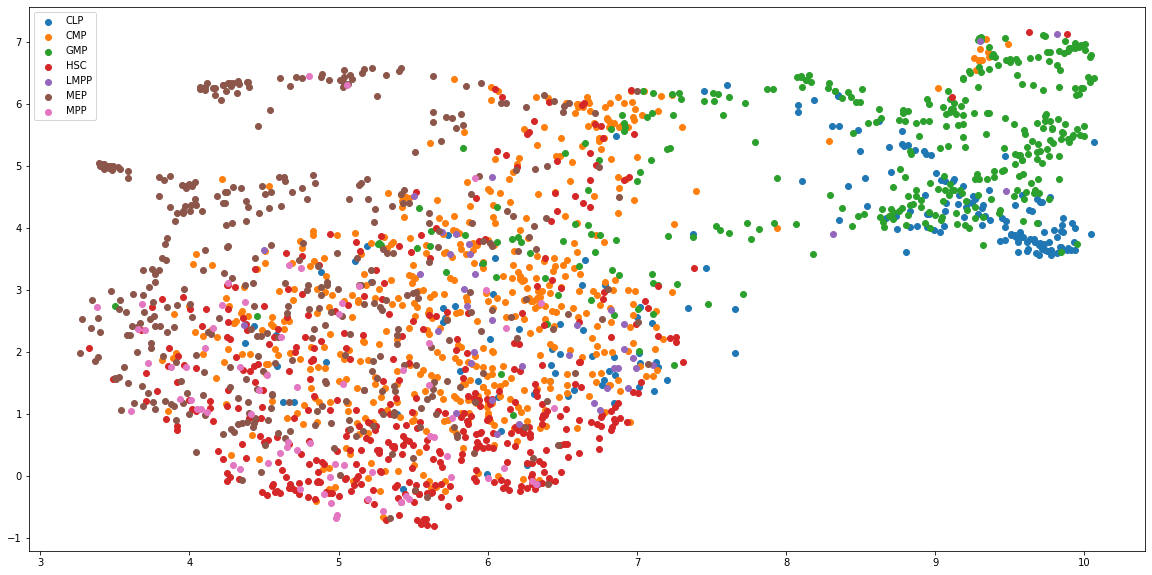

In [21]:
fig = plt.figure(figsize = (20,10))
ax = fig.subplots(1)
for cluster in np.unique(celltypes_rna):
    ax.scatter(x_umap[np.where(celltypes_rna == cluster)[0],0], x_umap[np.where(celltypes_rna == cluster)[0],1], label = cluster)

ax.legend()

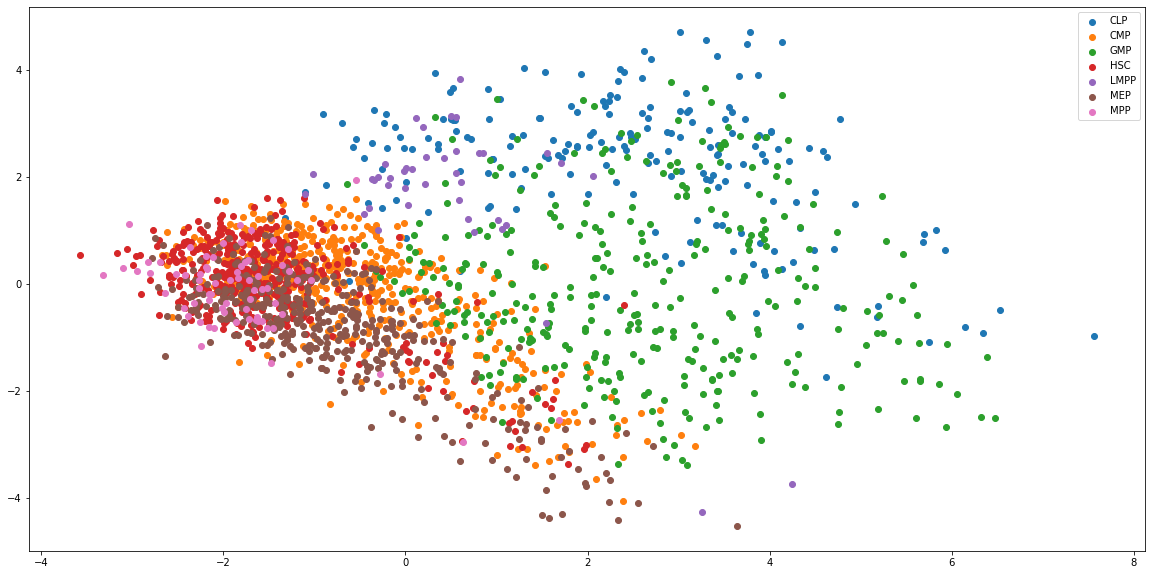

In [22]:
pca_op = PCA(n_components = 2)
x_pca = pca_op.fit_transform(scRNA.values)
fig = plt.figure(figsize = (20,10))
ax = fig.subplots(1)
for cluster in np.unique(celltypes_rna):
    ax.scatter(x_pca[np.where(celltypes_rna == cluster)[0],0], x_pca[np.where(celltypes_rna == cluster)[0],1], label = cluster)

ax.legend()

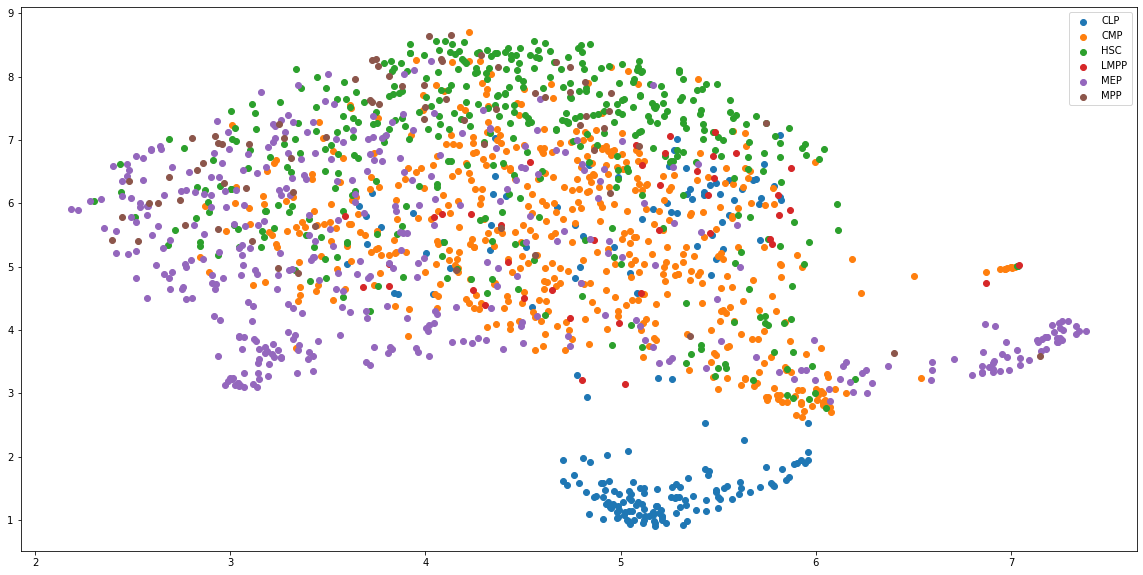

In [23]:
GMP_idx = np.where(celltypes_rna == "GMP")[0]
indices = np.ones((celltypes_rna.shape[0],))
indices[GMP_idx] = 0
indices = (indices == 1)
scRNA_1head2 = scRNA.iloc[indices,:]
celltypes_rna_1head2 = celltypes_rna[indices]
umap_op = umap.UMAP(n_components=2, n_neighbors = 15)
x_umap = umap_op.fit_transform(scRNA_1head2.values)
pca_op = PCA(n_components = 2)
x_pca = pca_op.fit_transform(scRNA_1head2.values)
fig = plt.figure(figsize = (20,10))
ax = fig.subplots(1)
for cluster in np.unique(celltypes_rna_1head2):
    ax.scatter(x_umap[np.where(celltypes_rna_1head2 == cluster)[0],0], x_umap[np.where(celltypes_rna_1head2 == cluster)[0],1], label = cluster)

ax.legend()

In [25]:
processed = "./remove_double_head/remove_GMP/"
with open(processed + "celltypes_rna.txt", "w") as fp:
    for cluster in celltypes_rna_1head2:
        fp.write(cluster + "\n")


scRNA_1head2.to_csv(processed + "count_rna.csv")

## Other
### Remove some cluster-trail
1. Trial 1 remove MEP

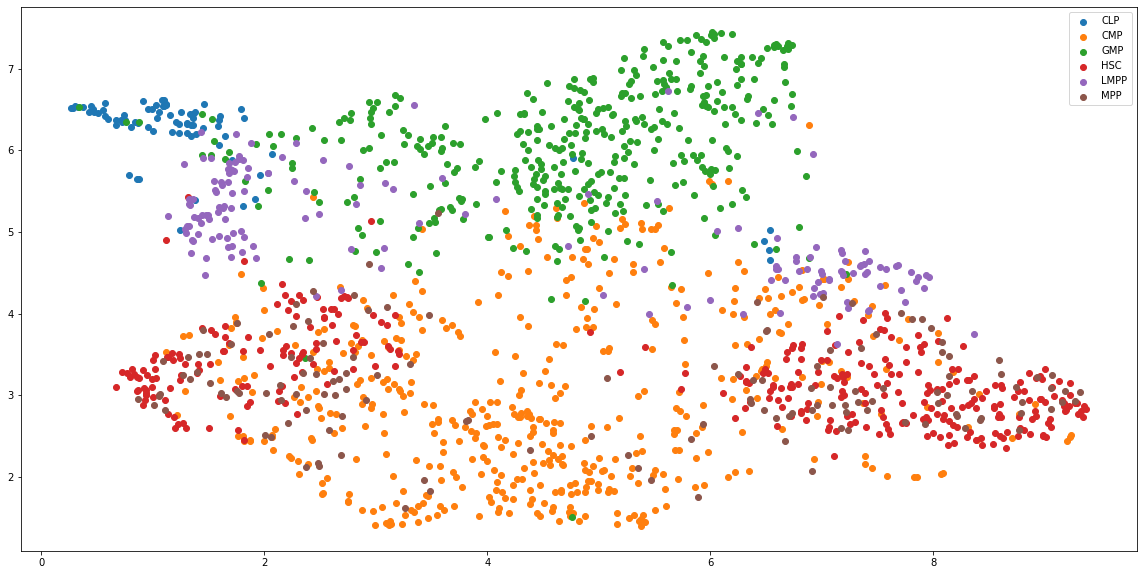

In [15]:
MEP_idx = np.where(celltypes_atac == "MEP")[0]
indices = np.ones((celltypes_atac.shape[0],))
indices[MEP_idx] = 0
indices = (indices == 1)
scATAC_sub = scATAC.iloc[indices,:]
celltypes_atac_sub = celltypes_atac[indices]
umap_op = umap.UMAP(n_components=2, n_neighbors = 15)
x_umap = umap_op.fit_transform(scATAC_sub.values)
pca_op = PCA(n_components = 2)
x_pca = pca_op.fit_transform(scATAC_sub.values)
fig = plt.figure(figsize = (20,10))
ax = fig.subplots(1)
for cluster in np.unique(celltypes_atac_sub):
    ax.scatter(x_umap[np.where(celltypes_atac_sub == cluster)[0],0], x_umap[np.where(celltypes_atac_sub == cluster)[0],1], label = cluster)

ax.legend()

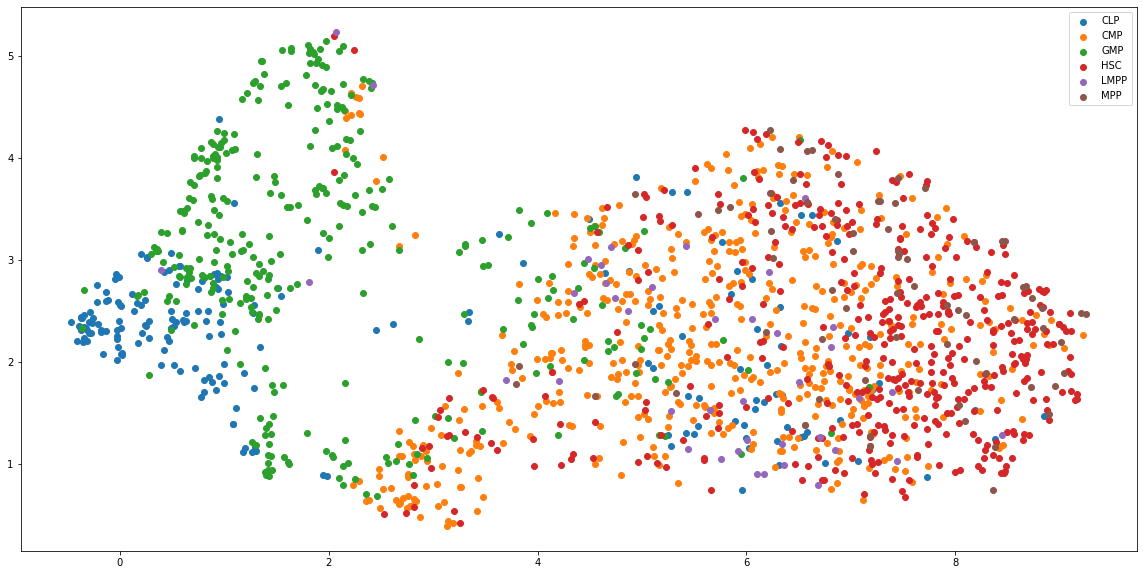

In [20]:
MEP_idx = np.where(celltypes_rna == "MEP")[0]
indices = np.ones((celltypes_rna.shape[0],))
indices[MEP_idx] = 0
indices = (indices == 1)
scRNA_sub = scRNA.iloc[indices,:]
celltypes_rna_sub = celltypes_rna[indices]
umap_op = umap.UMAP(n_components=2, n_neighbors = 5)
x_umap = umap_op.fit_transform(scRNA_sub.values)
pca_op = PCA(n_components = 2)
x_pca = pca_op.fit_transform(scRNA_sub.values)
fig = plt.figure(figsize = (20,10))
ax = fig.subplots(1)
for cluster in np.unique(celltypes_rna_sub):
    ax.scatter(x_umap[np.where(celltypes_rna_sub == cluster)[0],0], x_umap[np.where(celltypes_rna_sub == cluster)[0],1], label = cluster)

ax.legend()

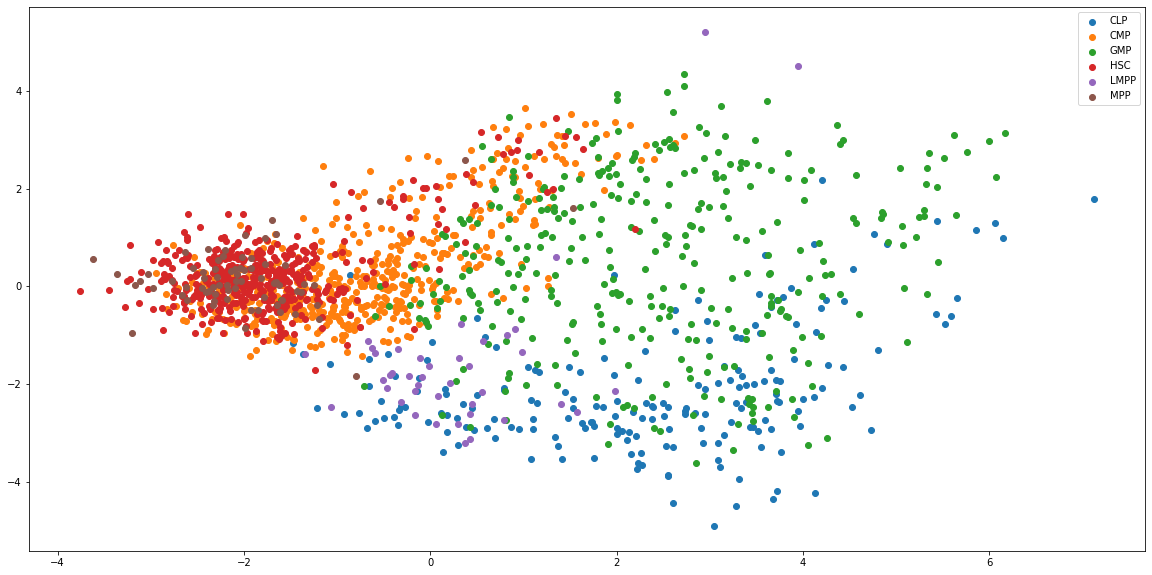

In [21]:
fig = plt.figure(figsize = (20,10))
ax = fig.subplots(1)
for cluster in np.unique(celltypes_rna_sub):
    ax.scatter(x_pca[np.where(celltypes_rna_sub == cluster)[0],0], x_pca[np.where(celltypes_rna_sub == cluster)[0],1], label = cluster)

ax.legend()

In [23]:
# processed = "./processed_remove_MEP_step1/"
# with open(processed + "celltypes_atac_1.txt", "w") as fp:
#     for cluster in celltypes_atac_sub:
#         fp.write(cluster + "\n")

# with open(processed + "celltypes_rna_1.txt", "w") as fp:
#     for cluster in celltypes_rna_sub:
#         fp.write(cluster + "\n")

# scRNA_sub.to_csv(processed + "count_rna_1.csv")
# scATAC_sub.to_csv(processed + "count_atac_1.csv")

2. Trial 2 remove LMPP, CLP, MEP, only linear trajectory of GMP is left

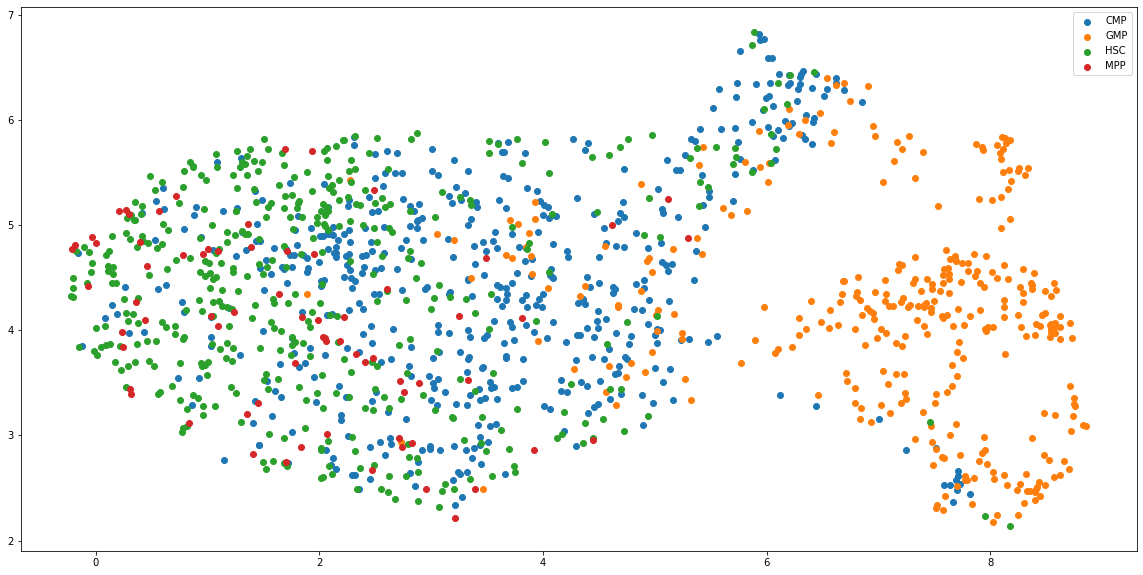

In [24]:
Lymphoid_idx = np.concatenate((np.where(celltypes_rna_sub == "LMPP")[0], np.where(celltypes_rna_sub == "CLP")[0]))
indices = np.ones((celltypes_rna_sub.shape[0],))
indices[Lymphoid_idx] = 0
indices = (indices == 1)
scRNA_sub2 = scRNA_sub.iloc[indices,:]
celltypes_rna_sub2 = celltypes_rna_sub[indices]
umap_op = umap.UMAP(n_components=2, n_neighbors = 5)
x_umap = umap_op.fit_transform(scRNA_sub2.values)
pca_op = PCA(n_components = 2)
x_pca = pca_op.fit_transform(scRNA_sub2.values)
fig = plt.figure(figsize = (20,10))
ax = fig.subplots(1)
for cluster in np.unique(celltypes_rna_sub2):
    ax.scatter(x_umap[np.where(celltypes_rna_sub2 == cluster)[0],0], x_umap[np.where(celltypes_rna_sub2 == cluster)[0],1], label = cluster)

ax.legend()

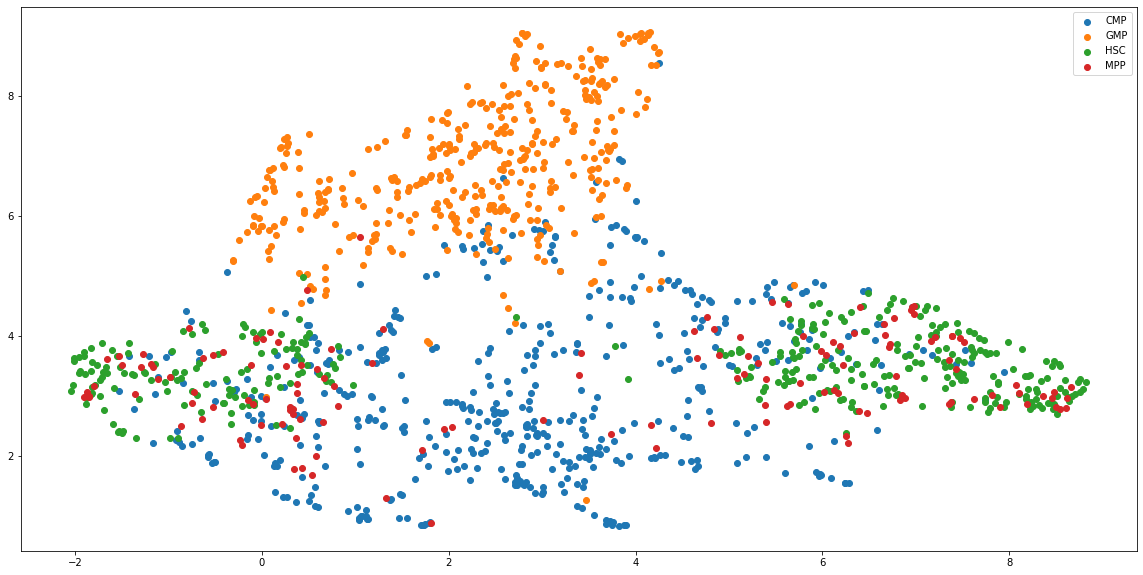

In [25]:
Lymphoid_idx = np.concatenate((np.where(celltypes_atac_sub == "LMPP")[0], np.where(celltypes_atac_sub == "CLP")[0]))
indices = np.ones((celltypes_atac_sub.shape[0],))
indices[Lymphoid_idx] = 0
indices = (indices == 1)
scATAC_sub2 = scATAC_sub.iloc[indices,:]
celltypes_atac_sub2 = celltypes_atac_sub[indices]
umap_op = umap.UMAP(n_components=2, n_neighbors = 5)
x_umap = umap_op.fit_transform(scATAC_sub2.values)
pca_op = PCA(n_components = 2)
x_pca = pca_op.fit_transform(scATAC_sub2.values)
fig = plt.figure(figsize = (20,10))
ax = fig.subplots(1)
for cluster in np.unique(celltypes_atac_sub2):
    ax.scatter(x_umap[np.where(celltypes_atac_sub2 == cluster)[0],0], x_umap[np.where(celltypes_atac_sub2 == cluster)[0],1], label = cluster)

ax.legend()

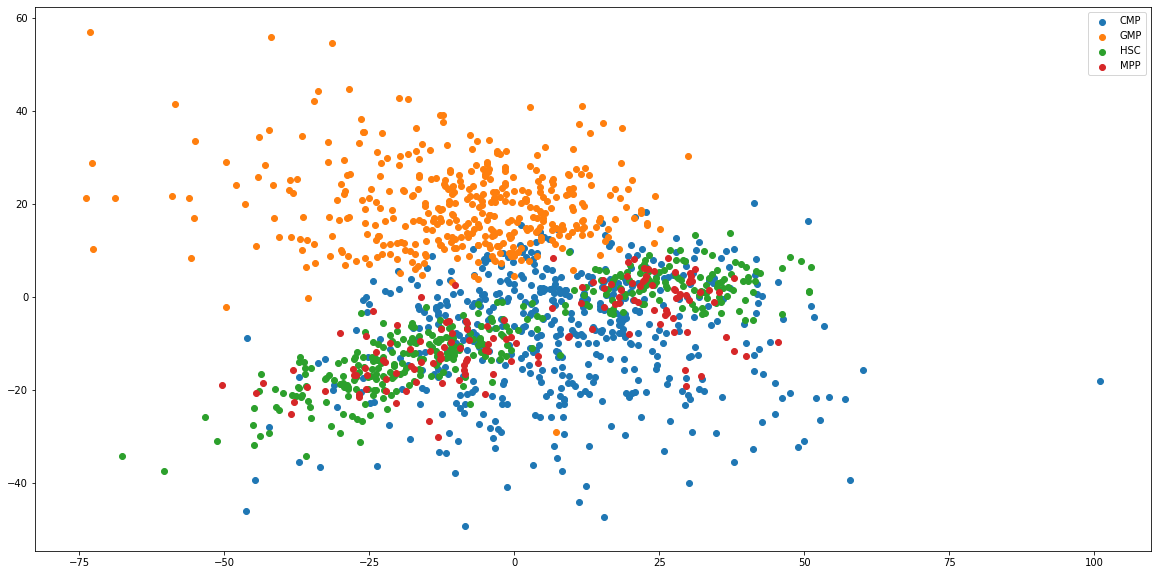

In [26]:
fig = plt.figure(figsize = (20,10))
ax = fig.subplots(1)
for cluster in np.unique(celltypes_atac_sub2):
    ax.scatter(x_pca[np.where(celltypes_atac_sub2 == cluster)[0],0], x_pca[np.where(celltypes_atac_sub2 == cluster)[0],1], label = cluster)

ax.legend()

In [28]:
processed = "./processed_remove_lymphoid_step2/"
with open(processed + "celltypes_atac_2.txt", "w") as fp:
    for cluster in celltypes_atac_sub2:
        fp.write(cluster + "\n")

with open(processed + "celltypes_rna_2.txt", "w") as fp:
    for cluster in celltypes_rna_sub2:
        fp.write(cluster + "\n")

scRNA_sub2.to_csv(processed + "count_rna_2.csv")
scATAC_sub2.to_csv(processed + "count_atac_2.csv")